In [2]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

selected_etfs = ['IEMG', 'EEM', 'ARKK', 'ARKW', 'TLT', 'SPTL', 'SHY', 'VGSH', 'SOXX', 'ITA']

prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']

train_cutoff = pd.Timestamp("2020-01-01")

prices = prices.dropna()
all_pairs = [('IEMG', 'EEM'), ('ARKK', 'ARKW'), ('TLT', 'SPTL'), ('SHY', 'VGSH'),('SOXX', 'ITA')]

pairs = ['IEMG-EEM', 'ARKK-ARKW', 'TLT-SPTL', 'SHY-VGSH', 'SOXX-ITA']

prices.info()


C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\1251384420.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARKK    2515 non-null   float64
 1   ARKW    2515 non-null   float64
 2   EEM     2515 non-null   float64
 3   IEMG    2515 non-null   float64
 4   ITA     2515 non-null   float64
 5   SHY     2515 non-null   float64
 6   SOXX    2515 non-null   float64
 7   SPTL    2515 non-null   float64
 8   TLT     2515 non-null   float64
 9   VGSH    2515 non-null   float64
dtypes: float64(10)
memory usage: 216.1 KB


In [3]:
def generate_labels(z, upper=1.8, lower=-1.8):
    return np.where(z > upper, -1,    # SHORT spread
           np.where(z < lower, 1,     # LONG spread
           0))                        # No trade

In [4]:
import pandas as pd
import statsmodels.api as sm

# Assumes `prices` is your DataFrame of adjusted-close prices,
# and `all_pairs` is a list of tuples: [(etf1, etf2), …]

lookback = 30
spread_records = []

for etf_a, etf_b in all_pairs:
    # Align prices and drop any NaNs for the pair
    pair_prices = pd.concat([prices[etf_a], prices[etf_b]], axis=1).dropna()
    a = pair_prices[etf_a]
    b = pair_prices[etf_b]

    # 1) Estimate hedge ratio via OLS
    model = sm.OLS(a, sm.add_constant(b)).fit()
    hedge_ratio = model.params[etf_b]

    # 2) Compute spread and rolling statistics
    spread = a - hedge_ratio * b
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    rolling_volatility = z_score.rolling(window=lookback).std()

    # 3) Build DataFrame for this pair
    df_pair = pd.DataFrame({
        'Date': spread.index,
        'pair': f"{etf_a}-{etf_b}",
        'spread': spread,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'rolling_volatility': rolling_volatility
    })

    spread_records.append(df_pair)

# Combine all pairs into a single long-form DataFrame
spread_long = pd.concat(spread_records, ignore_index=True)

# label feature
spread_long['label'] = generate_labels(spread_long['z_score'])

# 4) Add lagged features for z_score and spread
spread_long['z_score_lag1'] = spread_long.groupby('pair')['z_score'].shift(1)
spread_long['spread_lag1'] = spread_long.groupby('pair')['spread'].shift(1)

spread_long['z_score_lag2'] = spread_long.groupby('pair')['z_score'].shift(2)
spread_long['spread_lag2'] = spread_long.groupby('pair')['spread'].shift(2)

spread_long['z_score_lag3'] = spread_long.groupby('pair')['z_score'].shift(3)
spread_long['spread_lag3'] = spread_long.groupby('pair')['spread'].shift(3)

spread_long['z_score_lag4'] = spread_long.groupby('pair')['z_score'].shift(4)
spread_long['spread_lag4'] = spread_long.groupby('pair')['spread'].shift(4)

spread_long['z_score_lag5'] = spread_long.groupby('pair')['z_score'].shift(5)
spread_long['spread_lag5'] = spread_long.groupby('pair')['spread'].shift(5)



# 5) Final cleanup
spread_long.dropna(inplace=True)
spread_long.sort_values(['pair', 'Date'], inplace=True)
spread_long.reset_index(drop=True, inplace=True)

# `spread_long` now contains columns:
# ['Date', 'pair', 'spread', 'rolling_mean', 'rolling_std',
#  'z_score', 'rolling_volatility', 'z_score_lag1', 'spread_lag1']


spread_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12285 entries, 0 to 12284
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12285 non-null  datetime64[ns]
 1   pair                12285 non-null  object        
 2   spread              12285 non-null  float64       
 3   rolling_mean        12285 non-null  float64       
 4   rolling_std         12285 non-null  float64       
 5   z_score             12285 non-null  float64       
 6   rolling_volatility  12285 non-null  float64       
 7   label               12285 non-null  int64         
 8   z_score_lag1        12285 non-null  float64       
 9   spread_lag1         12285 non-null  float64       
 10  z_score_lag2        12285 non-null  float64       
 11  spread_lag2         12285 non-null  float64       
 12  z_score_lag3        12285 non-null  float64       
 13  spread_lag3         12285 non-null  float64   

In [5]:
from sklearn.preprocessing import LabelEncoder


le_pairs = LabelEncoder()
spread_long['pair_encoded'] = le_pairs.fit_transform(spread_long['pair'])

print(spread_long['pair_encoded'])


0        0
1        0
2        0
3        0
4        0
        ..
12280    4
12281    4
12282    4
12283    4
12284    4
Name: pair_encoded, Length: 12285, dtype: int64


In [6]:
# features = ['z_score_lag1', 'rolling_mean', 'z_score', 'z_score_lag3','z_score_lag2']
features = ['z_score_lag1', 'z_score', 'z_score_lag3','z_score_lag2',
            'z_score_lag4','spread_lag3','spread_lag5',
            'rolling_std','pair_encoded'
            ]
target = 'label'


train_spread_long = spread_long[spread_long['Date'] < train_cutoff]
test_spread_long = spread_long[spread_long['Date'] >= train_cutoff]

print(train_spread_long['Date'])


label_map = {-1: 0, 0: 1, 1: 2}

train_x = train_spread_long[features]
train_y = train_spread_long[target].map(label_map)

test_x = test_spread_long[features]
test_y = test_spread_long['label'].map(label_map)



0       2015-03-27
1       2015-03-30
2       2015-03-31
3       2015-04-01
4       2015-04-02
           ...    
11023   2019-12-24
11024   2019-12-26
11025   2019-12-27
11026   2019-12-30
11027   2019-12-31
Name: Date, Length: 6000, dtype: datetime64[ns]


In [7]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit



model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class (long, short, neutral)
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [2, 3, 5],
    'gamma':           [0,1,5], 
    'learning_rate':   [0.01, 0.05, 0.1], # 0.02
    'subsample':       [0.5, 0.7], # 0.6,0.8,1
    'colsample_bytree':[0.5, 0.7], # 0.6,0.8,1
    'min_child_weight':[10,20] # new
}

# def build_dummy_df(X, spread_long_df):
#     """
#     Given:
#       - X:               a DataFrame of just your model features, indexed by integer or Date
#       - spread_long_df:  the master DataFrame with columns ['Date','pair','spread',…]
#     Returns a backtest‐ready DataFrame with:
#       - Date as index
#       - pair, spread columns carried over from spread_long_df
#       - all the columns in X
#     """
#     # 1) pull the spread+pair rows matching X’s index
#     #    (if X is integer‐indexed, this assumes spread_long_df was reset_index first)
#     df = spread_long_df.loc[X.index, ['Date','pair','spread']].copy()
    
#     # 2) attach the feature columns (positional, to avoid index misalignment)
#     for col in X.columns:
#         df[col] = X[col].values
    
#     # 3) set Date as the index for time‐series operations
#     df.set_index('Date', inplace=True)
#     return df

# def apply_hold(signal_raw: pd.Series, hold_period: int) -> pd.Series:
#     """
#     Once a non‐zero signal appears, carry it forward for up to `hold_period` rows.
#     Zeros (no trade) become NaN, get ffilled, then back to 0.
#     """
#     return (
#         signal_raw
#           .replace(0, np.nan)
#           .ffill(limit=hold_period)
#           .fillna(0)
#           .astype(int)
#     )

# def sharpe_as_scorer(estimator, X, y_true):
#     # 1) get raw codes & probs
#     raw = estimator.predict(X)
#     # 2) build a tiny backtest: half capital each leg, 5-day hold
#     df = build_dummy_df(X)  # includes spread & prices
#     df['signal_raw'] = raw
#     df['signal']     = apply_hold(df['signal_raw'], hold_period=5)
#     df['spread_ret'] = df['spread'].pct_change().shift(-1)
#     daily  = (df['signal'] * df['spread_ret']*100).groupby(df['Date']).sum()
#     return (daily.mean()/daily.std()) * np.sqrt(252)

# sharpe_scorer = make_scorer(sharpe_as_scorer, greater_is_better=True)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',    # accuracy, or your custom backtest metric
    cv=TimeSeriesSplit(n_splits=5),             # e.g. 3-fold CV (use TimeSeriesSplit for time series)
    verbose=1,
    n_jobs=-1
)

grid.fit(train_x, train_y)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model.predict(train_x)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)

from sklearn.metrics import classification_report

y_pred = best_model.predict(train_x)
print(classification_report(train_y, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits

c:\Users\anair26\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:28:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 0.5, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.7}
Best CV score: 0.999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       353
           1       1.00      1.00      1.00      5216
           2       0.99      0.98      0.99       431

    accuracy                           1.00      6000
   macro avg       1.00      0.99      1.00      6000
weighted avg       1.00      1.00      1.00      6000



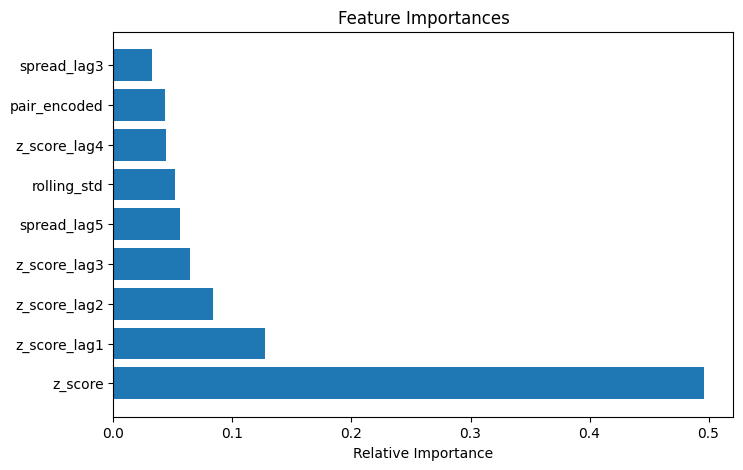

[0.03271377 0.04354659 0.04439605 0.05173998 0.05599846 0.06390763
 0.08381463 0.1277352  0.49614775]


In [8]:
def feature_importance(Model,feature_df):

    fi = Model.feature_importances_
    feat_names = feature_df.columns

    # Create a sorted bar chart
    indices = np.argsort(fi)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(feat_names[indices], fi[indices])
    plt.title("Feature Importances")
    plt.xlabel("Relative Importance")
    plt.show()

    print(np.sort(fi))

feature_importance(best_model,train_x)

In [9]:
threshold_long = 0.6
threshold_short = 0.6



In [10]:
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 0) PARAMETERS
hold_period     = 3    # how many days to hold any new +1/–1 signal
initial_capital = 100    # dollars per pair
# ─────────────────────────────────────────────────────────────────────────────

# 1) RAW MODEL SIGNAL
# ------------------------------------------------------------------
# best_model.predict returns array of {0,1,2} per your label_map:
#   0 ↔ original label -1 (short), 1 ↔ 0 (no‐trade), 2 ↔ 1 (long)
inv_map = {v:k for k,v in label_map.items()}  
raw_codes = best_model.predict(test_x)
# assign by position so we avoid any index errors:
test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)



C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\2305257067.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)


In [11]:

# 2) HOLDING WINDOW
# ------------------------------------------------------------------
# Once you get a +1 or -1, forward‐fill it for `hold_period` days, per pair
test_spread_long['signal'] = (
    test_spread_long
      .groupby('pair')['signal_raw']
      .transform(lambda s: s.replace(0, np.nan).ffill(limit=hold_period))
      .fillna(0)
      .astype(int)
)

test_spread_long['spread_ret'] = (
    test_spread_long
      .groupby('pair')['spread']
      .transform(lambda x: x.pct_change().shift(-1))
)

test_spread_long

# t2 = test_spread_long.groupby('pair')['signal_raw'].apply(lambda s: s.replace(0, np.nan).ffill(limit=hold_period)).fillna(0).astype(int)

# t2

C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\1546794504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal'] = (
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\1546794504.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_ret'] = (


,Date,pair,spread,rolling_mean,rolling_std,z_score,rolling_volatility,label,z_score_lag1,spread_lag1,...,z_score_lag3,spread_lag3,z_score_lag4,spread_lag4,z_score_lag5,spread_lag5,pair_encoded,signal_raw,signal,spread_ret
1200,2020-01-02,ARKK-ARKW,5.941560,7.061693,0.381742,-2.934264,1.266779,1,-1.665169,6.432590,...,-0.692044,6.728972,-0.223225,6.891303,0.561637,7.271531,0,1,1,-0.028358
1201,2020-01-03,ARKK-ARKW,5.773067,7.026575,0.446997,-2.804291,1.383471,1,-2.934264,5.941560,...,-1.952822,6.271113,-0.692044,6.728972,-0.223225,6.891303,0,1,1,-0.019281
1202,2020-01-06,ARKK-ARKW,5.661758,6.984499,0.511707,-2.584959,1.461822,1,-2.804291,5.773067,...,-1.665169,6.432590,-1.952822,6.271113,-0.692044,6.728972,0,1,1,0.004201
1203,2020-01-07,ARKK-ARKW,5.685543,6.952461,0.561275,-2.257217,1.520195,1,-2.584959,5.661758,...,-2.934264,5.941560,-1.665169,6.432590,-1.952822,6.271113,0,1,1,0.076466
1204,2020-01-08,ARKK-ARKW,6.120294,6.933531,0.579767,-1.402695,1.528858,0,-2.257217,5.685543,...,-2.804291,5.773067,-2.934264,5.941560,-1.665169,6.432590,0,0,1,-0.025084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12280,2024-12-23,TLT-SPTL,-7.397453,-7.261834,0.092334,-1.468785,0.973037,0,-1.459537,-7.386774,...,0.107150,-7.230850,-0.699180,-7.294748,-1.154609,-7.331962,4,0,1,-0.010470
12281,2024-12-24,TLT-SPTL,-7.320005,-7.267740,0.090099,-0.580079,0.932539,0,-1.468785,-7.397453,...,-2.286979,-7.449352,0.107150,-7.230850,-0.699180,-7.294748,4,0,1,0.006661
12282,2024-12-26,TLT-SPTL,-7.368764,-7.275314,0.088663,-1.053983,0.895368,0,-0.580079,-7.320005,...,-1.459537,-7.386774,-2.286979,-7.449352,0.107150,-7.230850,4,0,0,-0.005656
12283,2024-12-27,TLT-SPTL,-7.327087,-7.274863,0.088353,-0.591085,0.889800,0,-1.053983,-7.368764,...,-1.468785,-7.397453,-1.459537,-7.386774,-2.286979,-7.449352,4,0,0,0.018015


In [12]:

# 3) NEXT-DAY SPREAD DIFF (not pct-change)
test_spread_long['spread_diff'] = (
    test_spread_long['spread']
      .diff()      # spread_t – spread_{t-1}
      .shift(-1)   # align so that today’s signal applies to tomorrow’s move
)

# 4) DOLLAR P&L ON THE SPREAD (raw-change version)
# --------------------------------------------------------
# We want $100 notional per pair in the spread itself.
# That means we buy (or short) N = 100 / spread_t units of the spread.
# Then PnL = signal * (spread_{t+1} - spread_t) * N

test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
                                 np.sign(test_spread_long['spread']) * 1,
                                 test_spread_long['spread'])

test_spread_long['position_size'] = initial_capital / test_spread_long['adjusted_spread']
test_spread_long['dollar_pnl'] = (
    test_spread_long['signal'] *
    test_spread_long['spread_diff'] *
    test_spread_long['position_size']
)



# test_spread_long['spread_diff'] = (
#     test_spread_long['spread'].diff().shift(-1)
# )

# test_spread_long['posi']

C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3069591832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_diff'] = (
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3069591832.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3069591832.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [13]:
subset = test_spread_long[test_spread_long['pair']=='ARKK-ARKW']

subset = subset[subset['Date'] > '2021-11-23']
subset = subset[subset['Date'] < '2021-11-30']


print(subset[['Date','spread']].tail(5))

print(test_spread_long['spread'].describe())


           Date    spread
1679 2021-11-24  0.609024
1680 2021-11-26  0.679258
1681 2021-11-29 -0.190090
count    6285.000000
mean      -17.454834
std        35.150536
min      -164.145066
25%        -7.065535
50%        -3.195993
75%         3.794903
max        25.168741
Name: spread, dtype: float64


In [14]:
# Helper: max drawdown
def max_drawdown(equity: pd.Series) -> float:
    """
    Compute maximum drawdown of an equity curve.
    Returns negative decimal, e.g. -0.25 for 25% drawdown.
    """
    peak = equity.cummax()
    dd   = (equity - peak) / peak
    return dd.min()

# 1) build_test_features unchanged
def build_test_features(spread_long_df, pair_name, features, train_cutoff):
    df = spread_long_df[(spread_long_df['pair'] == pair_name) & 
                        (spread_long_df['Date'] >= train_cutoff)].copy()
    df.set_index('Date', inplace=True)
    X_test = df[features]
    return X_test, df

# 2) build_prices_for_pair unchanged
def build_prices_for_pair(pair_name, prices_df, test_index):
    etf1, etf2 = pair_name.split('-')
    price_df = prices_df[[etf1, etf2]].loc[test_index].copy()
    price_df.columns = ['price_long', 'price_short']
    return price_df

# 3) simulate_portfolio (daily PnL accumulation)
def simulate_portfolio(X_test, y_pred_label, prices_df,
                       initial_cash_per_pair=100.0, holding_period=3):
    """
    Runs a backtest for one pair, accumulating PnL by exit date rather than overwriting equity.
    Returns:
      - daily_pnl: pd.Series of daily PnL
      - equity:    pd.Series of cumulative equity (initial_cash + cumsum daily_pnl)
      - trades:    list of trade dicts
    """
    # Prepare empty daily PnL series, indexed by test dates
    pnl_by_date = pd.Series(0.0, index=X_test.index)
    trades = []

    # Loop over raw signals and generate trades
    for i, signal in enumerate(y_pred_label):
        # cannot complete a full holding period
        if i + holding_period >= len(X_test):
            break
        if signal == 0:
            continue

        entry_idx = i
        exit_idx  = i + holding_period

        pin  = prices_df.iloc[entry_idx]
        pout = prices_df.iloc[exit_idx]
        notional = initial_cash_per_pair
        half      = notional / 2

        p_long_in   = pin['price_long']
        p_short_in  = pin['price_short']
        p_long_out  = pout['price_long']
        p_short_out = pout['price_short']

        if signal == 1:
            # Long ETF1, Short ETF2
            shares_long  = half / p_long_in
            shares_short = half / p_short_in
            pnl = (shares_long  * (p_long_out  - p_long_in)
                 + shares_short * (p_short_in - p_short_out))
            direction = "Long ETF1 / Short ETF2"
        else:
            # Short ETF1, Long ETF2
            shares_short = half / p_long_in
            shares_long  = half / p_short_in
            pnl = (shares_long  * (p_short_out - p_short_in)
                 + shares_short * (p_long_in  - p_long_out))
            direction = "Short ETF1 / Long ETF2"

        # Accumulate PnL on the exit date
        pnl_by_date.iat[exit_idx] += pnl

        # Log trade details
        trades.append({
            "entry_date": X_test.index[entry_idx],
            "exit_date":  X_test.index[exit_idx],
            "direction":  direction,
            "pnl":        pnl,
            "notional":   notional
        })

    # Build equity curve: initial cash + cumulative PnL
    equity = pnl_by_date.cumsum() + initial_cash_per_pair
    return pnl_by_date, equity, trades

# 4) run_full_simulation with correct PnL aggregation
# def run_full_simulation(
#     spread_long,    # DataFrame
#     prices,         # price DataFrame
#     pairs,          # list of pair strings
#     best_model,     # trained model
#     features,       # list of feature names
#     train_cutoff,   # date cutoff
#     initial_cash_per_pair=100,
#     holding_period=3
# ):
#     total_initial = initial_cash_per_pair * len(pairs)
#     combined_daily_pnl = pd.Series(0.0, index=spread_long['Date'].unique())
#     combined_daily_pnl.index = pd.to_datetime(combined_daily_pnl.index)
#     pair_trade_counts = {}
#     pair_pnls = {}
#     pair_sharpes = {}
#     pair_drawdowns = {}

#     plt.figure(figsize=(14, 6))
#     for pair in pairs:
#         X_test, _ = build_test_features(spread_long, pair, features, train_cutoff)
#         prices_df = build_prices_for_pair(pair, prices, X_test.index)

#         raw_codes = best_model.predict(X_test)
#         inv_map = {v: k for k, v in label_map.items()}
#         y_pred_label = np.vectorize(inv_map.get)(raw_codes)

#         daily_pnl, equity, trades = simulate_portfolio(
#             X_test,
#             y_pred_label,
#             prices_df,
#             initial_cash_per_pair=initial_cash_per_pair,
#             holding_period=holding_period
#         )

#         # aggregate per-pair daily PnL into the combined series
#         combined_daily_pnl = combined_daily_pnl.add(daily_pnl, fill_value=0)

#         # performance metrics on this pair's equity
#         returns = equity.pct_change().dropna()
#         sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else np.nan
#         mdd    = max_drawdown(equity)

#         pair_sharpes[pair]   = sharpe
#         pair_drawdowns[pair] = mdd
#         pair_trade_counts[pair] = len(trades)
#         pair_pnls[pair] = [t['pnl'] for t in trades]

#         # plot this pair's equity
#         sns.lineplot(x=equity.index, y=equity.values, label=pair)

#     # finalize plot
#     plt.title("Equity Curve by Pair")
#     plt.xlabel("Date")
#     plt.ylabel("Portfolio Value ($)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

    # # compute overall metrics
    # combined_equity = combined_daily_pnl.cumsum() + total_initial
    # agg_return  = combined_equity.iloc[-1] / total_initial - 1
    # agg_sharpe  = (combined_daily_pnl.mean() / combined_daily_pnl.std()) * np.sqrt(252)
    # agg_mdd     = max_drawdown(combined_equity)

    # print(f"Final Portfolio Value: ${combined_equity.iloc[-1]:,.2f}")
    # print(f"Aggregate Return: {agg_return:.2%}")
    # print(f"Total Sharpe Ratio: {agg_sharpe:.2f}")
    # print(f"Total Max Drawdown: {agg_mdd:.2%}")

    # print("Trade Summary:")
    # for pair, count in pair_trade_counts.items():
    #     total_pnl = sum(pair_pnls[pair])
    #     avg_pnl   = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
    #     print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    # print("Sharpe Ratios by Pair:")
    # for pair, sharpe in pair_sharpes.items():
    #     print(f"  {pair}: Sharpe = {sharpe:.2f}")

    # print("Max Drawdown by Pair:")
    # for pair, mdd in pair_drawdowns.items():
    #     print(f"  {pair}: Max Drawdown = {mdd:.2%}")

        # … after your loop over pairs, where you’ve built combined_daily_pnl …

    # Build the combined equity curve
    # combined_equity = combined_daily_pnl.cumsum() + total_initial

    # # 1) Aggregate return
    # agg_return = combined_equity.iloc[-1] / total_initial - 1

    # # 2) Aggregate daily % returns
    # daily_pct = combined_daily_pnl / total_initial

    # # 3) Aggregate Sharpe on percent returns
    # agg_sharpe = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)

    # # 4) Aggregate max drawdown on equity curve
    # agg_mdd = max_drawdown(combined_equity)

    # print(f"Final Portfolio Value: ${combined_equity.iloc[-1]:,.2f}")
    # print(f"Aggregate Return:       {agg_return:.2%}")
    # print(f"Aggregate Sharpe:       {agg_sharpe:.2f}")
    # print(f"Aggregate Max Drawdown: {agg_mdd:.2%}\n")

    # # 5) Per‐pair metrics now also on daily_pct, not equity.pct_change()
    # print("Per-pair performance:")
    # for pair in pairs:
    #     pnl = pd.Series(pair_pnls[pair], index=[t['exit_date'] for t in trades_by_pair[pair]])
    #     # build daily PnL series & pct-return
    #     daily_pnl_pair = pnl.groupby(pnl.index).sum()
    #     daily_pct_pair = daily_pnl_pair / initial_cash_per_pair

    #     sharpe = (daily_pct_pair.mean() / daily_pct_pair.std()) * np.sqrt(252) \
    #              if daily_pct_pair.std() != 0 else np.nan
    #     mdd    = max_drawdown((daily_pct_pair.cumsum() + 1) * initial_cash_per_pair)

    #     total_pnl = daily_pnl_pair.sum()
    #     avg_pnl   = daily_pnl_pair.mean()

    #     print(f" {pair}: Total PnL ${total_pnl:.2f}, Avg PnL ${avg_pnl:.2f}, "
    #           f"Sharpe {sharpe:.2f}, Max DD {mdd:.2%}")


    # return combined_equity, pair_pnls, pair_trade_counts, pair_sharpes, pair_drawdowns

def run_full_simulation(
    spread_long, 
    prices, 
    pairs, 
    best_model, 
    features, 
    train_cutoff,
    initial_cash_per_pair=100,
    holding_period=3
):
    total_initial = initial_cash_per_pair * len(pairs)

    # dict to accumulate each pair's daily PnL series
    pair_daily_pnl_map = {}

    pair_trade_counts = {}
    pair_pnls         = {}
    pair_sharpes      = {}
    pair_drawdowns    = {}

    plt.figure(figsize=(8, 5))

    # 1) Loop per pair, simulate and collect daily PnL
    for pair in pairs:
        X_test, _   = build_test_features(spread_long, pair, features, train_cutoff)
        prices_df   = build_prices_for_pair(pair, prices, X_test.index)

        raw_codes   = best_model.predict(X_test)
        inv_map     = {v: k for k, v in label_map.items()}
        y_pred_lbl  = np.vectorize(inv_map.get)(raw_codes)

        # simulate: returns daily_pnl (Series), equity (Series), and trades (list)
        daily_pnl, equity, trades = simulate_portfolio(
            X_test, 
            y_pred_lbl, 
            prices_df,
            initial_cash_per_pair=initial_cash_per_pair,
            holding_period=holding_period
        )

        # store the daily PnL for later metrics
        pair_daily_pnl_map[pair] = daily_pnl
        pair_trade_counts[pair]  = len(trades)
        pair_pnls[pair]          = [t['pnl'] for t in trades]

        # plot the equity curve
        sns.lineplot(x=equity.index, y=equity.values, label=pair, alpha=0.9, linewidth=2)

    plt.title("XGBoost Portfolio Equity Curve", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)

    plt.legend(title="Pair", frameon=True)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # 2) Build combined daily PnL and equity
    combined_daily_pnl = sum(pair_daily_pnl_map.values())
    combined_equity    = combined_daily_pnl.cumsum() + total_initial

    # 3) Aggregate metrics
    agg_return = combined_equity.iloc[-1] / total_initial - 1
    # daily_pct  = combined_daily_pnl / total_initial
    # agg_sharpe = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)
    agg_daily_ret = combined_equity.pct_change().fillna(0)
    agg_sharpe    = agg_daily_ret.mean() / agg_daily_ret.std() * np.sqrt(252)
    agg_mdd    = max_drawdown(combined_equity) * -1

    print(f"\nFinal Portfolio Value: ${combined_equity.iloc[-1]:,.2f}")
    print(f"Aggregate Return:       {agg_return:.2%}")
    print(f"Aggregate Sharpe:       {agg_sharpe:.2f}")
    print(f"Aggregate Max Drawdown: {agg_mdd:.2%}\n")

    # 4) Per-pair performance
    print("Per-pair performance:")
    for pair in pairs:
        pnl_series    = pair_daily_pnl_map[pair]
        total_pnl     = pnl_series.sum()
        avg_pnl       = pnl_series.mean()
        pct_returns   = pnl_series / initial_cash_per_pair
        sharpe        = (pct_returns.mean() / pct_returns.std()) * np.sqrt(252) \
                          if pct_returns.std() != 0 else np.nan
        equity_curve  = pct_returns.cumsum() + initial_cash_per_pair
        mdd           = max_drawdown(equity_curve) * -100

        print(
            f"  {pair}: "
            f"Trades={pair_trade_counts[pair]} | "
            f"Total PnL=${total_pnl:.2f} | "
            f"Avg PnL=${avg_pnl:.2f} | "
            f"Sharpe={sharpe:.2f} | "
            f"Max DD={mdd:.2%}"
        )

    return combined_equity, pair_pnls, pair_trade_counts, pair_sharpes, pair_drawdowns



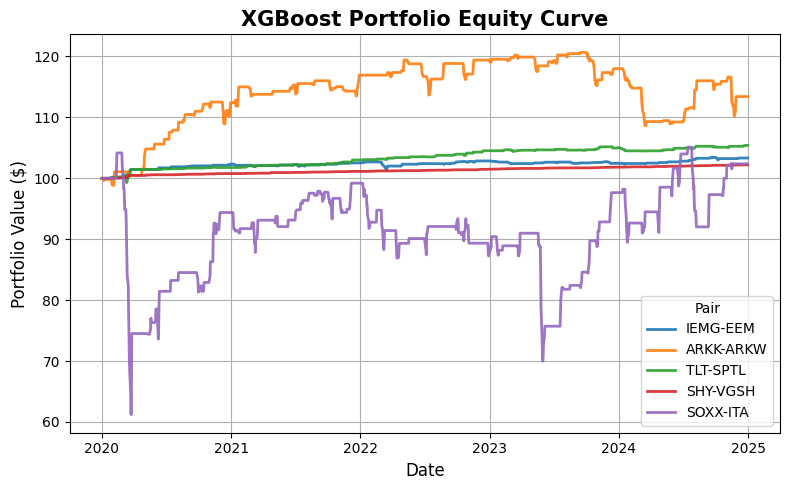


Final Portfolio Value: $526.76
Aggregate Return:       5.35%
Aggregate Sharpe:       0.40
Aggregate Max Drawdown: 8.03%

Per-pair performance:
  IEMG-EEM: Trades=211 | Total PnL=$3.33 | Avg PnL=$0.00 | Sharpe=1.26 | Max DD=1.27%
  ARKK-ARKW: Trades=251 | Total PnL=$13.42 | Avg PnL=$0.01 | Sharpe=0.60 | Max DD=12.00%
  TLT-SPTL: Trades=175 | Total PnL=$5.42 | Avg PnL=$0.00 | Sharpe=1.28 | Max DD=1.22%
  SHY-VGSH: Trades=126 | Total PnL=$2.22 | Avg PnL=$0.00 | Sharpe=3.02 | Max DD=0.02%
  SOXX-ITA: Trades=249 | Total PnL=$2.37 | Avg PnL=$0.00 | Sharpe=0.04 | Max DD=42.94%


In [15]:
combined_equity, pair_pnls, trade_counts, sharpe_ratios, pair_drawdowns = run_full_simulation(
    spread_long, 
    prices, 
    pairs, 
    best_model, 
    features, 
    train_cutoff,
    initial_cash_per_pair=100,   # still split $100 50/50 per trade
    holding_period=3            # still hold each signal for 5 days
)




C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\4057403272.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pair', y='total_pnl', data=metrics, palette='tab10')


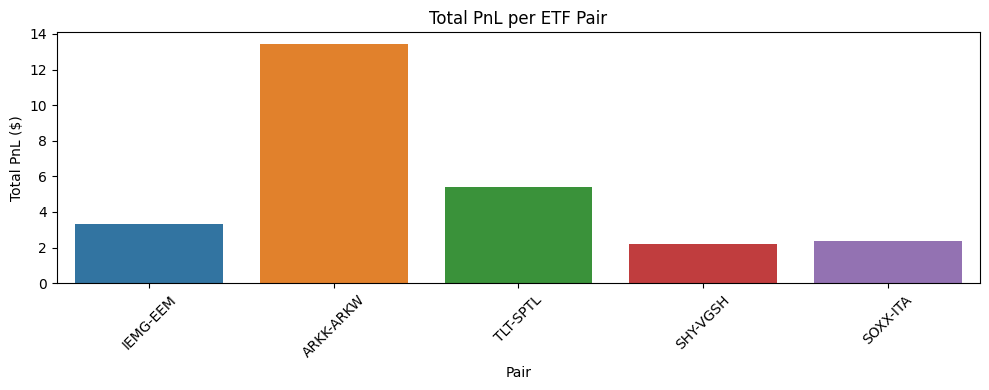

C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\4057403272.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pair', y='avg_pnl', data=metrics, palette='tab10')


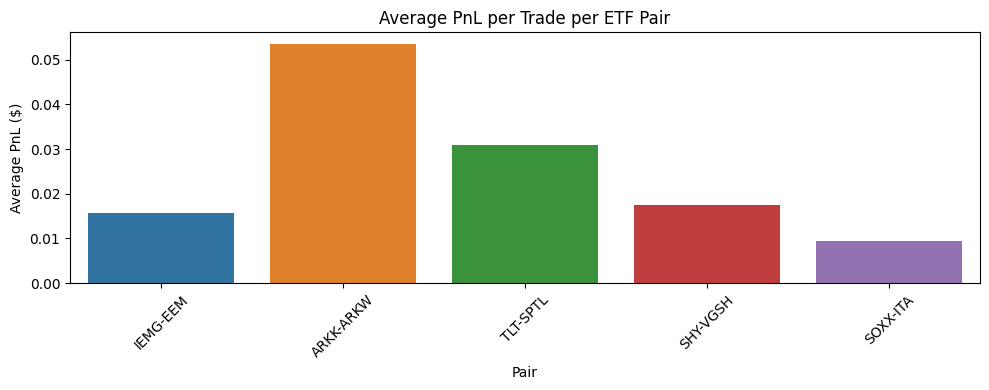

In [16]:
metrics = pd.DataFrame({
    'pair': list(pair_pnls.keys()),
    'total_pnl': [sum(pnls) for pnls in pair_pnls.values()],
    'avg_pnl':   [np.mean(pnls) if len(pnls)>0 else 0 
                  for pnls in pair_pnls.values()]
})

# 2) Plot Total PnL per pair
plt.figure(figsize=(10,4))
sns.barplot(x='pair', y='total_pnl', data=metrics, palette='tab10')
plt.title('Total PnL per ETF Pair')
plt.xlabel('Pair')
plt.ylabel('Total PnL ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Plot Average PnL per Trade per pair
plt.figure(figsize=(10,4))
sns.barplot(x='pair', y='avg_pnl', data=metrics, palette='tab10')
plt.title('Average PnL per Trade per ETF Pair')
plt.xlabel('Pair')
plt.ylabel('Average PnL ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:

# 1. Download daily price data (use Adjusted Close)
start_date = "2020-01-01"
end_date   = "2024-12-31"
spy = yf.download("SPY", start=start_date, end=end_date, progress=False)["Close"]


C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3596899091.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date, progress=False)["Close"]


In [18]:


# 2. Simulate buy-and-hold
initial_investment = 500.0
first_price        = spy.iloc[0]                      # <-- scalar!
shares             = initial_investment / first_price

# portfolio value over time
portfolio = shares * spy

# 3. Compute daily PnL and returns
daily_pnl     = portfolio.diff().fillna(0)
daily_returns = portfolio.pct_change().fillna(0)

# 4. Metrics
sharpe_ratio           = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
sharpe_ratio = sharpe_ratio.iloc[0] # numpy float, use .iloc 

rolling_max            = portfolio.cummax()
drawdown               = (portfolio - rolling_max) / rolling_max
max_drawdown           = drawdown.min() 
max_drawdown = max_drawdown.iloc[0] # numpy float, use .iloc


average_pnl            = daily_pnl.mean()
average_pnl = average_pnl.iloc[0]

total_pnl              = portfolio.iloc[-1] - initial_investment
total_pnl = total_pnl.iloc[0]

total_return_pct       = (portfolio.iloc[-1] / initial_investment - 1) * 100
total_return_pct = total_return_pct.iloc[0]

final_portfolio_value  = portfolio.iloc[-1]
final_portfolio_value = final_portfolio_value.iloc[0]

sharpe_ratio          = float(sharpe_ratio)
max_drawdown          = float(max_drawdown) * -100
average_pnl           = float(average_pnl)
total_pnl             = float(total_pnl)
total_return_pct      = float(total_return_pct)
final_portfolio_value = float(final_portfolio_value)
shares = float(shares)



C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\635508794.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  shares = float(shares)


In [19]:
print("SPY Buy-and-Hold Simulation (2020-01-01 to 2024-12-31)")
print(f"  Initial Investment         : ${initial_investment:,.2f}")
print(f"  Shares Purchased          : {shares:,.4f}")
print()
print("Metrics:")
print(f"  Sharpe Ratio (annualized) : {sharpe_ratio:.4f}")
print(f"  Max Drawdown              : {max_drawdown:.4f}%")
print(f"  Average Daily PnL ($)     : ${average_pnl:,.2f}")
print(f"  Total PnL ($)             : ${total_pnl:,.2f}")
print(f"  Total Return (%)          : {total_return_pct:.2f}%")
print(f"  Final Portfolio Value ($) : ${final_portfolio_value:,.2f}")


SPY Buy-and-Hold Simulation (2020-01-01 to 2024-12-31)
  Initial Investment         : $500.00
  Shares Purchased          : 1.6700

Metrics:
  Sharpe Ratio (annualized) : 0.7447
  Max Drawdown              : 33.7173%
  Average Daily PnL ($)     : $0.38
  Total PnL ($)             : $476.48
  Total Return (%)          : 95.30%
  Final Portfolio Value ($) : $976.48


In [20]:
for i in selected_etfs:

    string = i + "_price"
    print(string)

    string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']




C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed

IEMG_price
EEM_price
ARKK_price



C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']


ARKW_price
TLT_price


[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']


SPTL_price
SHY_price
VGSH_price


[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\anair26\AppData\Local\Temp\ipykernel_6360\3794888421.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  string = yf.download(i,start = '2015-01-01', end = '2024-12-31')['Close']


SOXX_price
ITA_price


[*********************100%***********************]  1 of 1 completed


In [ ]:
# initial_alloc = 50

# # 3) Compute shares purchased per ETF
# shares = initial_alloc / prices.iloc[0]

# # 4) Build per‐ETF portfolio value series
# portfolio = prices.mul(shares, axis=1)

# # 5) Compute metrics for each ETF
# metrics = []
# for ticker in selected_etfs:
#     port      = portfolio[ticker]
#     daily_ret = port.pct_change().fillna(0)
#     daily_pnl = port.diff().fillna(0)

#     metrics.append({
#         'Ticker'            : ticker,
#         'Sharpe Ratio'      : float(daily_ret.mean() / daily_ret.std() * np.sqrt(252)),
#         'Max Drawdown'      : float(((port - port.cummax())/port.cummax()).min()),
#         'Average Daily PnL' : float(daily_pnl.mean()),
#         'Total PnL'         : float(port.iloc[-1] - initial_alloc),
#         'Total Return (%)'  : float((port.iloc[-1]/initial_alloc - 1)*100),
#         'Final Value ($)'   : float(port.iloc[-1])
#     })

# # 6) Build the Aggregate portfolio
# agg_port = portfolio.sum(axis=1)          # sum across ETFs each day
# agg_daily_ret = agg_port.pct_change().fillna(0)
# agg_daily_pnl = agg_port.diff().fillna(0)

# etf_1 = agg_daily_pnl.cumsum() + 500

# agg_metrics = {
#     'Ticker'            : 'Aggregate',
#     'Sharpe Ratio'      : float(agg_daily_ret.mean() / agg_daily_ret.std() * np.sqrt(252)),
#     'Max Drawdown'      : float(((agg_port - agg_port.cummax())/agg_port.cummax()).min()),
#     'Average Daily PnL' : float(agg_daily_pnl.mean()),
#     'Total PnL'         : float(agg_port.iloc[-1] - initial_alloc*len(selected_etfs)),
#     'Total Return (%)'  : float((agg_port.iloc[-1]/(initial_alloc*len(selected_etfs)) - 1)*100),
#     'Final Value ($)'   : float(agg_port.iloc[-1])
# }

# metrics.append(agg_metrics)

# # 7) Create DataFrame and print
# metrics_df = pd.DataFrame(metrics).set_index('Ticker')
# pd.options.display.float_format = '{:,.4f}'.format

# print(f"\nBuy-and-Hold Metrics (${initial_alloc:.0f} per ETF; {start_date}–{end_date})\n")
# print(metrics_df)

# # 8) Plot ETF prices and aggregate portfolio value
# plt.figure(figsize=(14,6))
# # (a) Price chart
# plt.subplot(1,2,1)
# for t in selected_etfs:
#     plt.plot(prices.index, prices[t], label=t)
# plt.title("ETF Adjusted Close Prices")
# plt.xlabel("Date"); plt.ylabel("Price ($)")
# plt.legend(ncol=2, fontsize='small')

# # (b) Aggregate portfolio value
# plt.subplot(1,2,2)
# plt.plot(agg_port.index, agg_port, color='black', linewidth=2)
# plt.title("Aggregate Portfolio Value")
# plt.xlabel("Date"); plt.ylabel("Value ($)")

# plt.tight_layout()
# plt.show()
import numpy as np
import matplotlib.pyplot as plt

# 1) Individual‐ETF equity curves ($50 each)
alloc_per_etf     = 50.0
shares_per_etf    = alloc_per_etf / prices.iloc[0]    # Series: 50 / first‐day prices
etf_indiv_equity  = prices.mul(shares_per_etf, axis=1)  # DataFrame: $‐value of each ETF

# 2) Plot individual ETFs
plt.figure(figsize=(12, 6))
for ticker in selected_etfs:
    plt.plot(etf_indiv_equity.index, etf_indiv_equity[ticker], label=ticker)
plt.title("Individual ETF Equity Curves ($50 allocation)")
plt.xlabel("Date")
plt.ylabel("Equity Value ($)")
plt.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

# 3) Aggregate equity curve ($50×10 = $500 total)
etf_agg_equity = etf_indiv_equity.sum(axis=1)
assert np.isclose(etf_agg_equity.iloc[0], alloc_per_etf * len(selected_etfs))

# 4) Plot aggregate
plt.figure(figsize=(12, 4))
plt.plot(etf_agg_equity.index, etf_agg_equity.values, color="black", lw=2,
         label=f"ETF Basket Aggregate (${alloc_per_etf*len(selected_etfs):.0f})")
plt.title("Aggregate ETF Basket Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Compute & append aggregate metrics
agg_daily_ret = etf_agg_equity.pct_change().fillna(0)
agg_daily_pnl = etf_agg_equity.diff().fillna(0)

agg_metrics = {
    'Sharpe Ratio'     : float(agg_daily_ret.mean()   / agg_daily_ret.std() * np.sqrt(252)),
    'Max Drawdown'     : float(((etf_agg_equity - etf_agg_equity.cummax())
                                / etf_agg_equity.cummax()).min()),
    'Average Daily PnL': float(agg_daily_pnl.mean()),
    'Total PnL'        : float(etf_agg_equity.iloc[-1]
                                - alloc_per_etf*len(selected_etfs)),
    'Total Return (%)' : float((etf_agg_equity.iloc[-1]
                                /(alloc_per_etf*len(selected_etfs)) - 1)*100),
    'Final Value ($)'  : float(etf_agg_equity.iloc[-1])
}

# metrics_df is your existing DataFrame with index = ticker
metrics_df.loc['ETF Basket'] = agg_metrics

# 6) Show updated metrics table
pd.options.display.float_format = '{:,.4f}'.format
print(metrics_df)


AttributeError: 'DataFrame' object has no attribute 'append'

50.0
ETF basket starts at: 500.0


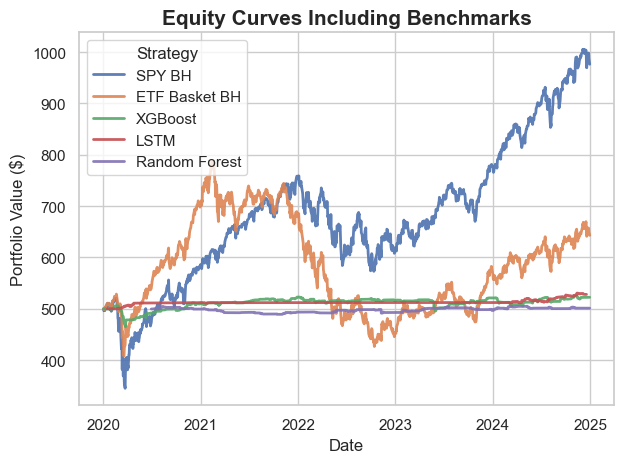

In [ ]:

# ——— 1) SPY buy-and-hold equity ———
# assume `spy` is your pd.Series of SPY adjusted closes
initial_spy = 500.0
shares_spy  = initial_spy / spy.iloc[0]
spy_equity  = shares_spy * spy


prices = (
    yf.download(
        selected_etfs,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )['Close']
)
# ——— 2) ETF basket buy-and-hold equity ———
# assume `prices` is your DataFrame of all ETF Adj Close,
# and you want $50 in each ticker in selected_etfs
initial_etf   = 50.0
shares_etf    = initial_etf / prices.iloc[0]     # Series of 50/first_price
print(initial_etf)
etf_equity    = (prices * shares_etf).sum(axis=1) # sum across tickers → total daily equity

# 2) Compute shares: $50 in each ETF on the first trading day
first_row       = prices.iloc[0]              # Series of 10 first‐day prices
shares_per_etf  = initial_etf / first_row # Series of 10 share‐counts

# 3) Build daily dollar‐value per ETF, then sum across ETFs
daily_values = prices.mul(shares_per_etf, axis=1)  # DataFrame, same shape as prices
etf_equity   = daily_values.sum(axis=1)            # Series, total daily equity

# sanity check: does it start at $500?
print("ETF basket starts at:", etf_equity.iloc[0])  # → should print 500.0

# 4) Now plot all three strategies on the same axes
#    (Assuming you already have `spy_equity` and `xgb_equity` Series defined)


# ——— 3) XGBoost strategy equity ———
# already returned from run_full_simulation:
#    combined_equity = pd.Series of your strategy’s daily equity
xgb_equity = combined_equity

# ——— 4) Restrict to common date range ———
start, end = "2020-01-01", "2024-12-31"
spy_eq = spy_equity.loc[start:end]
etf_equity = etf_equity.loc[start:end]
xgb_eq = xgb_equity.loc[start:end]

lstm_eq = pd.read_csv("lstm_equity.csv", index_col = 0, parse_dates=True).squeeze()
rf_eq = pd.read_csv("rf_equity.csv", index_col = 0, parse_dates = True).squeeze()

sns.set_theme(style="whitegrid", font_scale=1)

plt.plot(spy_eq.index, spy_eq.values, label="SPY BH", alpha=0.9, linewidth=2)
plt.plot(etf_equity.index, etf_equity.values, label="ETF Basket BH", alpha=0.9, linewidth=2)
plt.plot(xgb_eq.index, xgb_eq.values, label="XGBoost", alpha=0.9, linewidth=2)
plt.plot(lstm_eq.index, lstm_eq.values, label="LSTM", alpha=0.9, linewidth=2)
plt.plot(rf_eq.index, rf_eq.values, label="Random Forest", alpha=0.9, linewidth=2)

plt.title("Equity Curves Including Benchmarks", fontsize=15, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)

plt.legend(title="Strategy", loc="upper left", frameon=True)
plt.tight_layout()
plt.grid(True)
plt.show()

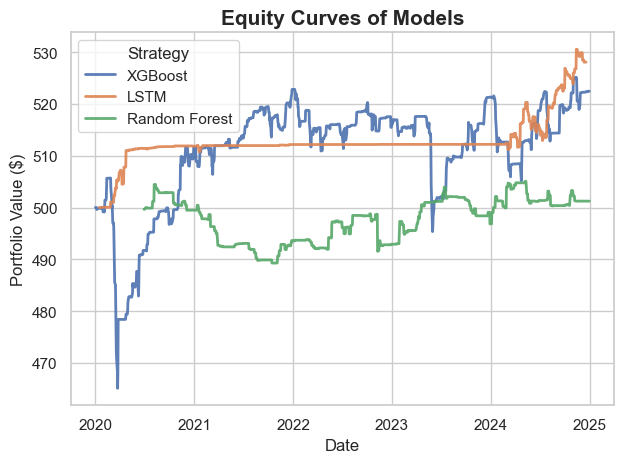

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1)

plt.plot(xgb_eq.index, xgb_eq.values, label="XGBoost", alpha=0.9, linewidth=2)
plt.plot(lstm_eq.index, lstm_eq.values, label="LSTM", alpha=0.9, linewidth=2)
plt.plot(rf_eq.index, rf_eq.values, label="Random Forest", alpha=0.9, linewidth=2)

plt.title("Equity Curves of Models", fontsize=15, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)

plt.legend(title="Strategy", loc="upper left", frameon=True)
plt.tight_layout()
plt.grid(True)
plt.show()

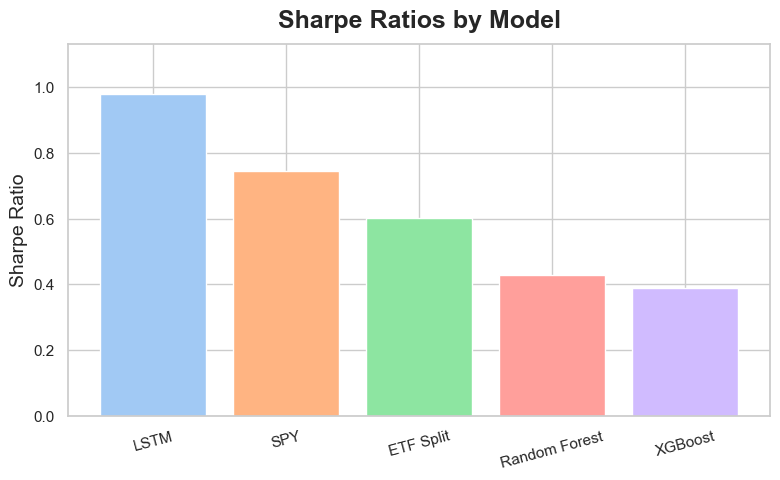

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.1)

all_sharpe = {
    "XGBoost": 0.39,
    "LSTM": 0.98,
    "Random Forest": 0.43,
    "SPY": 0.7447,
    "ETF Split": 0.6009,
}

sorted_sharpe = dict(sorted(all_sharpe.items(), key=lambda x: x[1], reverse=True))

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    sorted_sharpe.keys(),
    sorted_sharpe.values(),
    color=sns.color_palette("pastel"),
)

ax.set_title("Sharpe Ratios by Model", fontsize=18, weight='bold', pad=12)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("Sharpe Ratio", fontsize=14)

ax.set_ylim(0, max(sorted_sharpe.values()) + 0.15)
ax.tick_params(axis='x', labelsize=11, rotation=15)
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

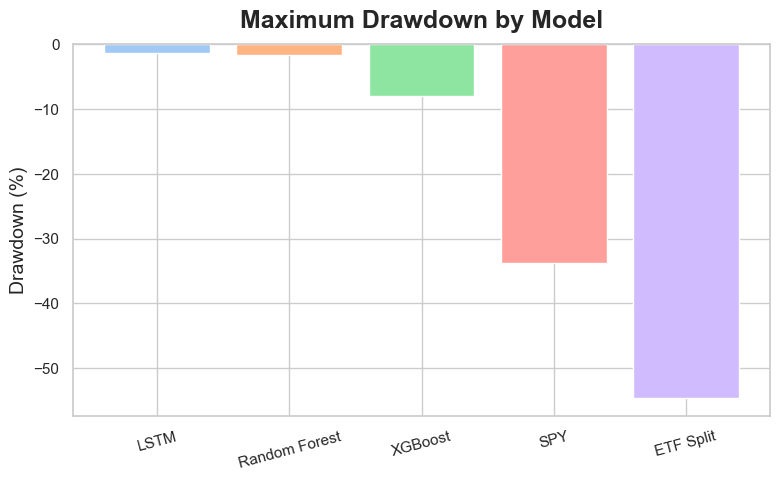

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.1)

all_drawdown = {
    "XGBoost": -8.03,
    "LSTM": -1.42,
    "Random Forest": -1.59,
    "SPY": -33.72,
    "ETF Split": -54.66,
}
sorted_drawdown = dict(sorted(all_drawdown.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    sorted_drawdown.keys(),
    sorted_drawdown.values(),
    color=sns.color_palette("pastel"),
)

ax.set_title("Maximum Drawdown by Model", fontsize=18, weight='bold', pad=12)
ax.set_ylabel("Drawdown (%)", fontsize=14)
ax.set_xlabel("")

ax.tick_params(axis='x', labelsize=11, rotation=15)
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

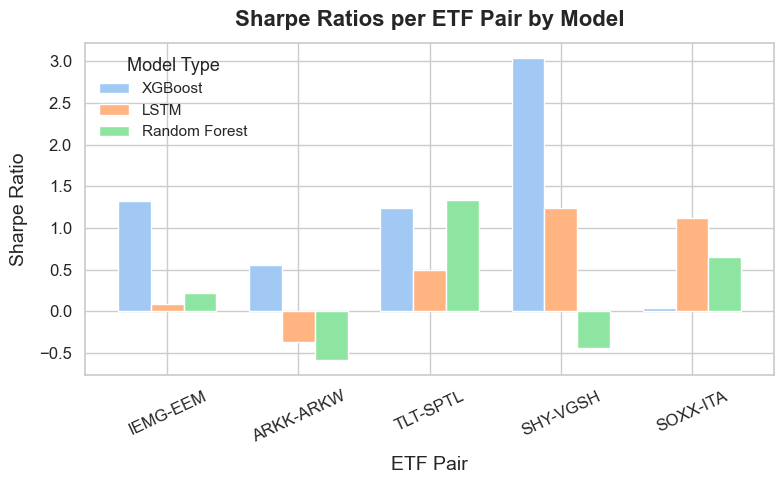

In [ ]:
categories = ['IEMG-EEM', 'ARKK-ARKW', 'TLT-SPTL', 'SHY-VGSH', 'SOXX-ITA']
XGB_sharpe = [1.32, 0.56, 1.24, 3.04, 0.04]
LSTM_sharpe = [0.09, -0.37, 0.49, 1.24, 1.12]
RF_sharpe = [0.22, -0.59, 1.33, -0.44, 0.65]

PP_sharpe = pd.DataFrame({
    'XGBoost': XGB_sharpe,
    'LSTM': LSTM_sharpe,
    'Random Forest': RF_sharpe
}, index=categories)
PP_sharpe.index.name = "Pair"

sns.set_theme(style="whitegrid")

ax = PP_sharpe.plot(
    kind='bar',
    figsize=(8, 5),
    rot=25,
    fontsize=12,
    width=0.75,
    color=sns.color_palette("pastel")
)

ax.set_title("Sharpe Ratios per ETF Pair by Model", fontsize=16, pad=12, weight='bold')
ax.set_xlabel('ETF Pair', fontsize=14, labelpad=8)
ax.set_ylabel('Sharpe Ratio', fontsize=14, labelpad=8)

ax.legend(
    title='Model Type',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()

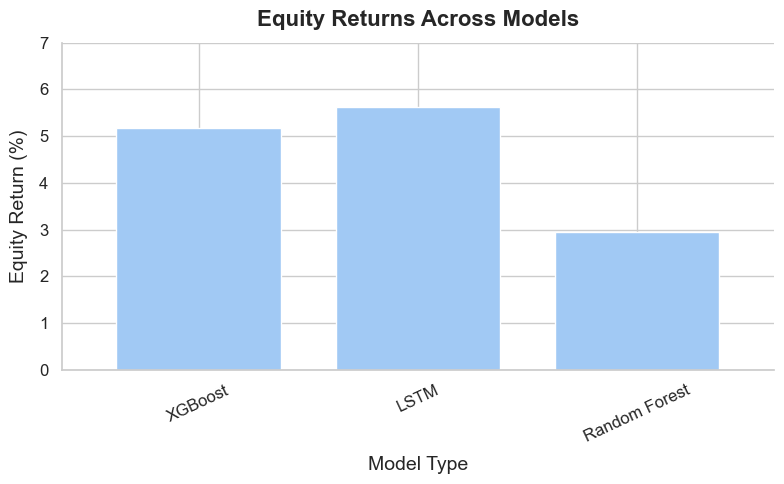

In [ ]:
all_return_pct = {
    'XGBoost': 5.18,
    'LSTM': 5.62,
    'Random Forest': 2.95
}

sns.set_theme(style="whitegrid")

return_df = pd.DataFrame(list(all_return_pct.items()), columns=["Model", "Return"])
return_df.set_index("Model", inplace=True)

ax = return_df.plot(
    kind='bar',
    figsize=(8, 5),
    rot = 25,
    fontsize=12,
    width = 0.75,
    legend = False,
    color = sns.color_palette("pastel")
)

ax.set_title("Equity Returns Across Models", fontsize=16, pad=12, weight='bold')
ax.set_xlabel("Model Type", fontsize=14, labelpad=8)
ax.set_ylabel("Equity Return (%)", fontsize=14, labelpad=8)

ax.set_ylim(0, 7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

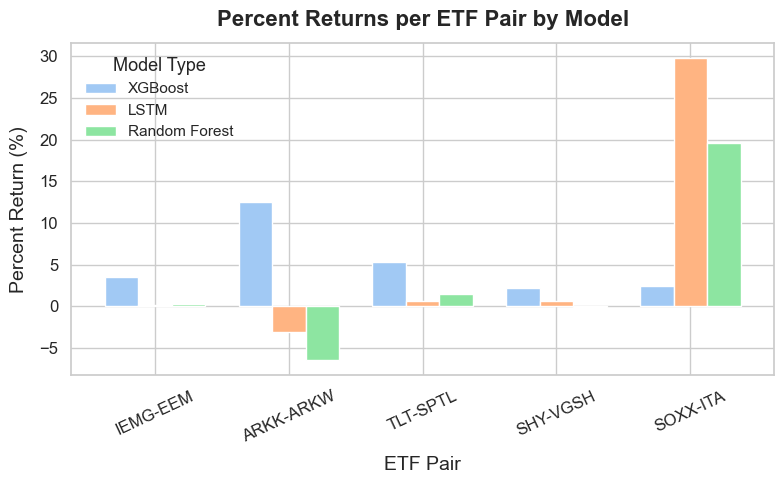

In [ ]:
categories = ['IEMG-EEM', 'ARKK-ARKW', 'TLT-SPTL', 'SHY-VGSH', 'SOXX-ITA']

XGB_return = [3.56, 12.46, 5.28, 2.23, 2.37]
LSTM_return = [0.12, -3.08, 0.63, 0.62, 29.8]
RF_return = [0.24, -6.5, 1.48, -0.07, 19.58]

PP_return = pd.DataFrame({
    'XGBoost': XGB_return,
    'LSTM': LSTM_return,
    'Random Forest': RF_return
}, index=categories)
PP_return.index.name = "Pair"

sns.set_theme(style="whitegrid")

ax = PP_return.plot(
    kind='bar',
    figsize=(8, 5),
    rot=25,
    fontsize=12,
    width=0.75,
    color=sns.color_palette("pastel")
)

ax.set_title("Percent Returns per ETF Pair by Model", fontsize=16, pad=12, weight='bold')
ax.set_xlabel('ETF Pair', fontsize=14, labelpad=8)
ax.set_ylabel('Percent Return (%)', fontsize=14, labelpad=8)

ax.legend(
    title='Model Type',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()

In [ ]:
# Drawdown per pair 

# XGB_draw = [-1.27,-12.19,-1.22,-0.02,-42.94]
# LSTM_draw = [-0.94,-4.73,-0.44,0,-6.35]
# RF_draw = [-0.31,-7.73,-0.11,-0.09,-7.85]

# PP_draw = pd.DataFrame({
#     'XGBoost':XGB_draw,
#     'LSTM':LSTM_draw,
#     'Random Forest':RF_draw
# }, index=categories)

# PP_draw.index.name = "Maximum Drawdown"

# ax = PP_draw.plot(
#     kind='bar',
#     figsize=(10, 5),
#     rot=45,              # rotate x-labels
#     fontsize=13,         # tick font size
# )

# ax.set_xlabel('Maximum Drawdowns per Pair', fontsize=14, labelpad=8)
# ax.set_ylabel('Maximum Drawdown (%)', fontsize=14, labelpad=8)
# ax.legend(title='Model Type', fontsize=12, title_fontsize=13)
# plt.tight_layout()
# plt.show()


Exception ignored in: <function ResourceTracker.__del__ at 0x10bfbda80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10ef89a80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child proces